In [2]:
import os
from pathlib import Path
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from PIL import ImageFont
from datetime import datetime
from tensorflow import keras
import tensorflow as tf 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

print(os.listdir(r"chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [4]:
data_dir = Path("/content/drive/Othercomputers/My Laptop/COEN 281/COEN 281/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray/chest_xray")

In [5]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [6]:
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

normal_cases = train_normal_dir.glob('*jpeg')
pneumonia_cases = train_pneumonia_dir.glob('*jpeg')

train_data = []
for img in normal_cases:
    train_data.append((img, 0))
for img in pneumonia_cases:
    train_data.append((img, 1))

train_df = pd.DataFrame(train_data, columns = ['Image Path', 'Label'], index = None)
train_df = train_df.sample(frac = 1.).reset_index(drop = True)
train_df.head(10)

,Image Path,Label
0,/content/drive/Othercomputers/My Laptop/COEN 2...,0
1,/content/drive/Othercomputers/My Laptop/COEN 2...,1
2,/content/drive/Othercomputers/My Laptop/COEN 2...,1
3,/content/drive/Othercomputers/My Laptop/COEN 2...,0
4,/content/drive/Othercomputers/My Laptop/COEN 2...,1
5,/content/drive/Othercomputers/My Laptop/COEN 2...,1
6,/content/drive/Othercomputers/My Laptop/COEN 2...,0
7,/content/drive/Othercomputers/My Laptop/COEN 2...,1
8,/content/drive/Othercomputers/My Laptop/COEN 2...,1
9,/content/drive/Othercomputers/My Laptop/COEN 2...,1


1    3875
0    1341
Name: Label, dtype: int64


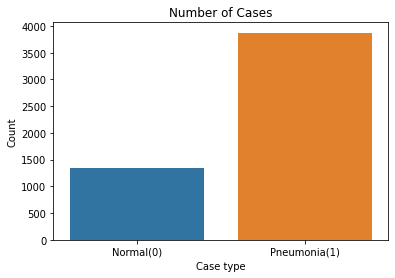

In [7]:
case_count = train_df['Label'].value_counts()
print(case_count)
plt.figure(figsize = (6, 4))
sns.barplot(x = case_count.index, y = case_count.values)
plt.title('Number of Cases')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(case_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

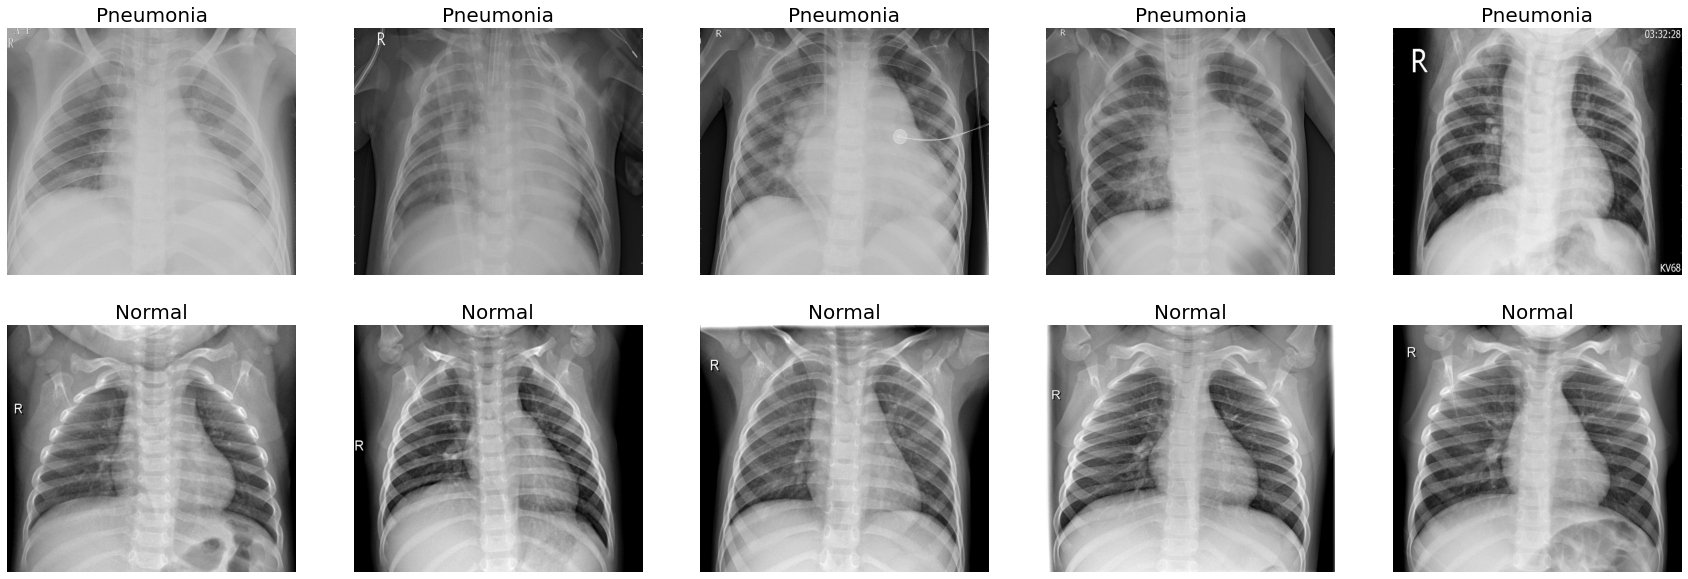

In [8]:
samples_pneumonia = (train_df[train_df['Label'] == 1]['Image Path'].iloc[:5]).tolist()
samples_normal = (train_df[train_df['Label'] == 0]['Image Path'].iloc[:5]).tolist()

total_samples = samples_pneumonia + samples_normal
del samples_pneumonia, samples_normal

f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(0, 10):
    img = imread(total_samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia", size=20)
    else:
        ax[i // 5, i % 5].set_title("Normal", size=20)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')

plt.show()

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def prepare_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = prepare_training_data(train_dir)
val = prepare_training_data(val_dir)
test = prepare_training_data(test_dir)

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-9-ebe511f0e1ff>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [12]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [14]:
generate_data = ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 30,
            zoom_range = 0.2, 
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            horizontal_flip = True,
            vertical_flip = False)

generate_data.fit(x_train)

In [15]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

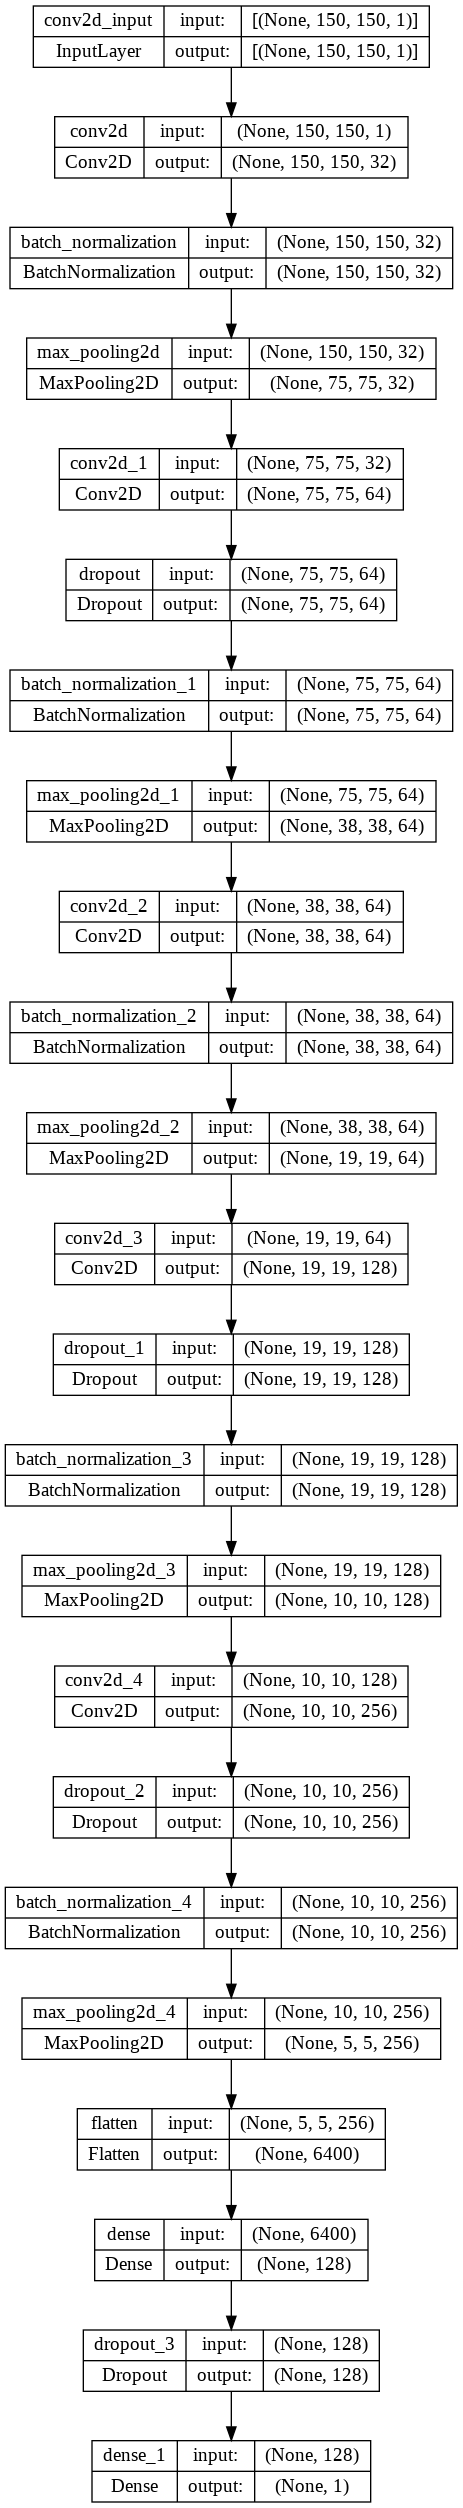

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# earlyStopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose=0, mode = 'max')
best_model = ModelCheckpoint('.mdl_wts.hdf5', save_best_only = True, monitor = 'val_accuracy')
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_accuracy',
                             save_best_only=True, 
                             mode='max')

In [ ]:
history = model.fit(generate_data.flow(x_train,y_train, batch_size = 32), 
                    epochs = 12, 
                    validation_data = generate_data.flow(x_val, y_val), 
                    callbacks = [checkpoint, learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8445
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model-001-0.844517-0.500000.h5
163/163 [==============================] - 176s 1s/step - loss: 0.4959 - accuracy: 0.8445 - val_loss: 25.9578 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9045
Epoch 2: val_accuracy did not improve from 0.50000
163/163 [==============================] - 152s 930ms/step - loss: 0.2572 - accuracy: 0.9045 - val_loss: 61.1133 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9227
Epoch 3: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 142s 872ms/step - loss: 0.2288 - accuracy: 0.9227 - val_loss: 5.3379 - val_accuracy: 0.5000 - l